##### The cell below is for you to keep track of the libraries used and install those libraries quickly
##### Ensure that the proper library names are used and the syntax of `%pip install PACKAGE_NAME` is followed

In [205]:
#%pip install pandas 
#%pip install matplotlib
#%pip install warnings
# add commented pip installation lines for packages used as shown above for ease of testing
# the line should be of the format %pip install PACKAGE_NAME 

## **DO NOT CHANGE** the filepath variable
##### Instead, create a folder named 'data' in your current working directory and 
##### have the .parquet file inside that. A relative path *must* be used when loading data into pandas

In [206]:
# Can have as many cells as you want for code
import pandas as pd
filepath = "./data/catB_train.parquet" 
# the initialised filepath MUST be a relative path to a folder named data that contains the parquet file

### **ALL** Code for machine learning and dataset analysis should be entered below. 
##### Ensure that your code is clear and readable.
##### Comments and Markdown notes are advised to direct attention to pieces of code you deem useful.

In [207]:
#Imports
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

# Reading in Data

In [208]:
df = pd.read_parquet(filepath)
df

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,is_consent_to_mail,is_consent_to_email,is_consent_to_call,is_consent_to_sms,is_valid_dm,is_valid_email,is_housewife_retiree,is_sg_pr,is_class_1_2,is_dependent_in_at_least_1_policy,f_ever_declined_la,hh_20,pop_20,hh_size,hh_size_est,annual_income_est,n_months_last_bought_products,flg_latest_being_lapse,flg_latest_being_cancel,recency_lapse,recency_cancel,tot_inforce_pols,tot_cancel_pols,ape_gi_42e115,ape_ltc_1280bf,ape_grp_6fc3e6,ape_grp_de05ae,ape_inv_dcd836,ape_grp_945b5a,ape_grp_6a5788,ape_ltc_43b9d5,ape_grp_9cdedf,ape_lh_d0adeb,ape_grp_1581d7,ape_grp_22decf,ape_lh_507c37,ape_lh_839f8a,ape_inv_e9f316,ape_gi_a10d1b,ape_gi_29d435,ape_grp_caa6ff,ape_grp_fd3bfb,ape_lh_e22a6a,ape_grp_70e1dd,ape_grp_e04c3a,ape_grp_fe5fb8,ape_gi_856320,ape_grp_94baec,ape_gi_058815,ape_grp_e91421,ape_lh_f852af,ape_lh_947b15,ape_32c74c,sumins_gi_42e115,sumins_ltc_1280bf,sumins_grp_6fc3e6,sumins_grp_de05ae,sumins_inv_dcd836,sumins_grp_945b5a,sumins_grp_6a5788,sumins_ltc_43b9d5,sumins_grp_9cdedf,sumins_lh_d0adeb,sumins_grp_1581d7,sumins_grp_22decf,sumins_lh_507c37,sumins_inv_e9f316,sumins_gi_a10d1b,sumins_gi_29d435,sumins_grp_caa6ff,sumins_grp_fd3bfb,sumins_lh_e22a6a,sumins_grp_70e1dd,sumins_grp_e04c3a,sumins_grp_fe5fb8,sumins_gi_856320,sumins_grp_94baec,sumins_gi_058815,sumins_grp_e91421,sumins_lh_f852af,sumins_lh_947b15,sumins_32c74c,prempaid_gi_42e115,prempaid_ltc_1280bf,prempaid_grp_6fc3e6,prempaid_grp_de05ae,prempaid_inv_dcd836,prempaid_grp_945b5a,prempaid_grp_6a5788,prempaid_ltc_43b9d5,prempaid_grp_9cdedf,prempaid_lh_d0adeb,prempaid_grp_1581d7,prempaid_grp_22decf,prempaid_lh_507c37,prempaid_lh_839f8a,prempaid_inv_e9f316,prempaid_gi_a10d1b,prempaid_gi_29d435,prempaid_grp_caa6ff,prempaid_grp_fd3bfb,prempaid_lh_e22a6a,prempaid_grp_70e1dd,prempaid_grp_e04c3a,prempaid_grp_fe5fb8,prempaid_gi_856320,prempaid_grp_94baec,prempaid_gi_058815,prempaid_grp_e91421,prempaid_lh_f852af,prempaid_lh_947b15,prempaid_32c74c,ape_839f8a,ape_e22a6a,ape_d0adeb,ape_c4bda5,ape_ltc,ape_507c37,ape_gi,f_hold_839f8a,f_hold_e22a6a,f_hold_d0adeb,f_hold_c4bda5,f_hold_ltc,f_hold_507c37,f_hold_gi,sumins_839f8a,sumins_e22a6a,sumins_d0adeb,sumins_c4bda5,sumins_ltc,sumins_507c37,sumins_gi,prempaid_839f8a,prempaid_e22a6a,prempaid_d0adeb,prempaid_c4bda5,prempaid_ltc,prempaid_507c37,prempaid_gi,lapse_ape_ltc_1280bf,lapse_ape_grp_6fc3e6,lapse_ape_grp_de05ae,lapse_ape_inv_dcd836,lapse_ape_grp_945b5a,lapse_ape_grp_6a5788,lapse_ape_ltc_43b9d5,lapse_ape_grp_9cdedf,lapse_ape_lh_d0adeb,lapse_ape_grp_1581d7,lapse_ape_grp_22decf,lapse_ape_lh_507c37,lapse_ape_lh_839f8a,lapse_ape_inv_e9f316,lapse_ape_grp_caa6ff,lapse_ape_grp_fd3bfb,lapse_ape_lh_e22a6a,lapse_ape_grp_70e1dd,lapse_ape_grp_e04c3a,lapse_ape_grp_fe5fb8,lapse_ape_grp_94baec,lapse_ape_grp_e91421,lapse_ape_lh_f852af,lapse_ape_lh_947b15,lapse_ape_32c74c,n_months_since_lapse_ltc_1280bf,n_months_since_lapse_grp_6fc3e6,n_months_since_lapse_grp_de05ae,n_months_since_lapse_inv_dcd836,n_months_since_lapse_grp_945b5a,n_months_since_lapse_grp_6a5788,n_months_since_lapse_ltc_43b9d5,n_months_since_lapse_grp_9cdedf,n_months_since_lapse_lh_d0adeb,n_months_since_lapse_grp_1581d7,n_months_since_lapse_grp_22decf,n_months_since_lapse_lh_507c37,n_months_since_lapse_lh_839f8a,n_months_since_lapse_inv_e9f316,n_months_since_lapse_grp_caa6ff,n_months_since_lapse_grp_fd3bfb,n_months_since_lapse_lh_e22a6a,n_months_since_lapse_grp_70e1dd,n_months_since_lapse_grp_e04c3a,n_months_since_lapse_grp_fe5fb8,n_months_since_lapse_grp_94baec,n_months_since_lapse_grp_e91421,n_months_since_lapse_lh_f852af,n_months_since_lapse_lh_947b15,n_months_since_lapse_32c74c,f_ever_bought_839f8a,f_ever_bought_e22a6a,f_ever_bought_d0adeb,f_ever_bought_c4bda5,f_ever_bought_ltc,f_ever_bought_507c37,f_ever_bought_

# Data Preprocessing Steps

## Fixing Target Column -> replace NANs with 0s, as they are not purchases

<AxesSubplot:>

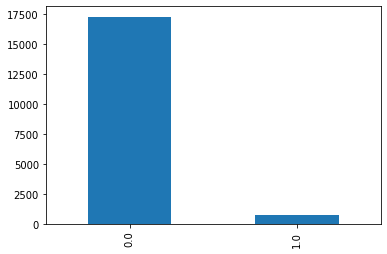

In [209]:
df['f_purchase_lh'].fillna(0, inplace=True)
df['f_purchase_lh'].value_counts().plot(kind='bar')

## Merging Columns that share prefixes
- Big assumption I'm making is that I can just take the mean of multiple columns that have a prefix, like 'ape_' -> I am mainly doing this to simplify the dataset and to reduce the number of columns without just blindly removing them. I am not too sure if this is the best way to approach this, but given I don't have enough domain knowledge to make a better decision, I will make this assumption for now and see if it makes sense later on

In [210]:
merge_prefixes = ['ape_', 'sumins_', 'prempaid_', 'f_hold_', 'lapse_ape_', 'n_months_since_lapse_', 'f_ever_bought_', 'n_months_last_bought_', 'f_ever_bought_', 'flg_hlthclaim_', 'recency_hlthclaim_']

for prefix in merge_prefixes:
    cols = [col for col in df.columns if col.startswith(prefix)]
    df[prefix + 'mean'] = df[cols].mean(axis=1)
    df.drop(cols, axis=1, inplace=True)

## Strategies to Remove Columns 

1. Remove columns with 100% missing values

2. First check which columns have a lot of missing values (more than 50%)
    - First check what the column represents and if it isn't useful for our analysis, drop or merge the column appropriately
        - Ex: 'f_ever_declined_la' can be made into a binary column, 1 if declined, 0 if not while a column like 'lapse_ape_...' can be merged with the other 'lapse_ape_...' columns
    - Big assumption that I'm making for many of these columns is that if the value is NAN, then the value is 0 -> My thought process is that I will make this assumption now and I will later see through metrics like correlation if it makes sense to keep using these columns or not. This is better than me just blindly dropping columns that have a lot of missing values

In [211]:
#Step 1 -> Remove columns with 100% missing values
threshold = 1
for col in df.columns:
    if df[col].isnull().sum() >= threshold*len(df):
        df.drop(col, axis=1, inplace=True)

# Step 2
threshold = 0.5
for col in df.columns:
    if df[col].isnull().sum() > threshold*len(df):
        continue #comment this line if you want prints
        print(col, df[col].isnull().sum()/len(df) * 100)
        print(df[col].nunique())
        if df[col].nunique() < 50:
            print(df[col].unique())
        print('', '\n')

# Deal with seemingly useful columns 1-by-1
df['f_ever_declined_la'].fillna(0, inplace=True)
df['recency_lapse'].fillna(0, inplace=True)
df['recency_cancel'].fillna(0, inplace=True)
df['tot_cancel_pols'].fillna(0, inplace=True)
df['flg_affconnect_show_interest_ever'].fillna(0, inplace=True)
df['flg_affconnect_ready_to_buy_ever'].fillna(0, inplace=True)
df['flg_hlthclaim_mean'].fillna(0, inplace=True)

# Now removing all columns with 50% missing values
threshold = 0.5
for col in df.columns:
    if df[col].isnull().sum() >= threshold*len(df):
        df.drop(col, axis=1, inplace=True)

## Now Dealing with the rest of the columns that have a low amount of missing values

1. The same set of rows (that made up around 5-6% of the dataset) had missing values for many of these columns, so I just removed them -> I made sure to check the target value for these rows and only 10 of the 1000+ rows were purchases, so I don't think I am losing too much information by removing these rows.
2. 

In [212]:
# Step 1 -> removing rows that share NANs across many columns
df = df[df['flg_substandard'].notna()]

for col in df.columns:
    if df[col].isnull().sum() > 0:
        print(col, df[col].isnull().sum()/len(df) * 100)
        print(df[col].nunique())
        if df[col].nunique() < 50:
            print(df[col].unique())
        print('', '\n')

race_desc 19.68429732595123
4
['Chinese' 'Others' 'Indian' None 'Malay']
 

ctrycode_desc 0.11779950524207798
26
['Singapore' 'Malaysia' 'United Kingdom' 'Brunei Darussalam' 'Hong Kong'
 'Indonesia' 'Philippines' 'Thailand' 'Australia' None 'Not Applicable'
 'United Arab Emirates' 'Japan' 'Spain' 'China' 'Taiwan (R.O.C)'
 'United States' 'Denmark' 'Unknown Country Code' 'South Africa' 'Sweden'
 'Ireland' 'New Zealand' 'Netherlands' 'Italy' 'Bosnia-Herzegovina'
 'Canada']
 

cltsex_fix 0.13546943102838968
2
['Female' 'Male' None]
 

hh_20 13.476263399693721
337
 

pop_20 13.476263399693721
866
 

hh_size 13.476263399693721
4871
 

hh_size_est 13.476263399693721
6
['1' '3' '4' '>4' '2' None '0']
 

annual_income_est 13.476263399693721
5
['C.60K-100K' 'D.30K-60K' 'A.ABOVE200K' 'B.100K-200K' 'E.BELOW30K' None]
 



In [213]:
df

,clntnum,race_desc,ctrycode_desc,clttype,stat_flag,min_occ_date,cltdob_fix,cltsex_fix,flg_substandard,flg_is_borderline_standard,flg_is_revised_term,flg_is_rental_flat,flg_has_health_claim,flg_has_life_claim,flg_gi_claim,flg_is_proposal,flg_with_preauthorisation,flg_is_returned_mail,is_consent_to_mail,is_consent_to_email,is_consent_to_call,is_consent_to_sms,is_valid_dm,is_valid_email,is_housewife_retiree,is_sg_pr,is_class_1_2,is_dependent_in_at_least_1_policy,f_ever_declined_la,hh_20,pop_20,hh_size,hh_size_est,annual_income_est,flg_latest_being_lapse,flg_latest_being_cancel,recency_lapse,recency_cancel,tot_inforce_pols,tot_cancel_pols,f_elx,f_mindef_mha,f_retail,flg_affconnect_show_interest_ever,flg_affconnect_ready_to_buy_ever,f_purchase_lh,ape_mean,sumins_mean,prempaid_mean,f_hold_mean,n_months_last_bought_mean,flg_hlthclaim_mean
19550,91b546e924,Chinese,Singapore,P,ACTIVE,2017-10-31,1974-05-09,Female,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,144,202,1.402778,1,C.60K-100K,0,0,29.0,0.0,3,0.0,0,0,1,0.0,0.0,0.0,46.972973,38.888889,2489.567568,0.285714,1.0,0.0
4600,896bae548c,Chinese,Singapore,P,ACTIVE,2007-05-23,1979-11-11,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,153,480,3.137255,3,D.30K-60K,0,0,140.0,0.0,1,0.0,0,0,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,45.0,0.0
13337,f364439ae6,Others,Singapore,P,ACTIVE,2019-08-31,1976-01-28,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,62,179,2.887097,3,A.ABOVE200K,0,0,0.0,0.0,1,0.0,0,0,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,47.0,0.0
15074,70f319cfe1,Chinese,Singapore,P,ACTIVE,2021-10-18,1976-03-19,Female,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1,4,4.000000,4,B.100K-200K,0,0,0.0,0.0,1,0.0,0,0,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,22.0,0.0
19724,2647a81328,Chinese,Singapore,P,ACTIVE,2018-07-20,1995-07-31,Female,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,114,478,4.192982,>4,E.BELOW30K,0,0,0.0,0.0,1,0.0,0,0,1,0.0,0.0,0.0,18.810811,22222.222222,996.972973,0.142857,62.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11284,3363260248,None,Singapore,P,LAPSED,2016-08-01,1994-05-24,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,85,273,3.211765,3,E.BELOW30K,0,0,86.0,0.0,1,0.0,0,0,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,36.0,0.0
11964,c3509f0aef,Chinese,Singapore,P,ACTIVE,1990-03-20,1948-12-16,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0,0,0.000000,0,B.100K-200K,0,0,0.0,0.0,1,0.0,0,0,1,0.0,0.0,0.0,200.432432,6666.666667,10622.918919,0.142857,407.0,0.0
5390,6e44cfb3e7,Chinese,Singapore,P,ACTIVE,2007-12-31,1967-12-06,Female,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,43,145,3.372093,3,D.30K-60K,0,0,0.0,0.0,1,0.0,0,0,1,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,101.0,0.0
860,dd4e362f9f,Others,Singapore,P,ACTIVE,2007-09-01,1986-04-01,Male,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,72,323,4.486111,>4,E.BELOW30K,1,0,46.0,0.0,2,0.0,0,1,0,0.0,0.0,0.0,1.945946,11111.111111,103.135135,0.142857,46.0,0.0


## The cell below is **NOT** to be removed
##### The function is to be amended so that it accepts the given input (dataframe) and returns the required output (list). 
##### It is recommended to test the function out prior to submission
-------------------------------------------------------------------------------------------------------------------------------
##### The hidden_data parsed into the function below will have the same layout columns wise as the dataset *SENT* to you
##### Thus, ensure that steps taken to modify the initial dataset to fit into the model are also carried out in the function below

In [214]:
def testing_hidden_data(hidden_data: pd.DataFrame) -> list:
    '''DO NOT REMOVE THIS FUNCTION.

The function accepts a dataframe as input and return an iterable (list)
of binary classes as output.

The function should be coded to test on hidden data
and should include any preprocessing functions needed for your model to perform. 
    
All relevant code MUST be included in this function.'''
    result = [] 
    return result

##### Cell to check testing_hidden_data function

In [215]:
# This cell should output a list of predictions.
test_df = pd.read_parquet(filepath)
test_df = test_df.drop(columns=["f_purchase_lh"])
print(testing_hidden_data(test_df))

[]


### Please have the filename renamed and ensure that it can be run with the requirements above being met. All the best!